<a href="https://colab.research.google.com/github/eduardodacostasoares/Data_Science/blob/master/cats_and_dogs_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# check whether GPU is provided
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Sun Apr 16 17:50:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |       

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O cats_and_dogs_filtered.zip

--2023-04-16 17:50:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.0MB/s    in 3.9s    

2023-04-16 17:50:33 (16.6 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
import os
import zipfile

local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('data/')
zip_ref.close()

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'data/cats_and_dogs_filtered/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
# test_dir = os.path.join(base_dir, 'test')

**Building our network**

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [8]:
from tensorflow.keras import optimizers

# compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

**Data preprocessing**

Devemos converter os dados em tensores de ponto flutuante. Devemos seguir as seguintes etapas:

Leia os arquivos de imagem.
Decodifique em pixels RGB
Converta-os em tensores de ponto flutuante.
Rescale de cada pixels de (0 a 255) para [0, 1]

O keras.preprocessing.image contém a classe ImageDataGenerator, que permite configurar geradores Python que podem transformar automaticamente arquivos de imagem em disco em lotes de tensores pré-processados. 


In [9]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Vamos dar uma olhada no formato dos arquivos gerados pelo python

Foram produzidos batches de imagens RGB de 150x150 (shape (20, 150, 150, 3)) e labels binárias (shape (20,))

20 é o número de amostras em cada batch (o tamanho do batch)

In [10]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


**Treinando o modelo**

Vamos ajustar nosso modelo aos dados usando o gerador, usando o método **fit_generator**

train_generator: (primeiro argumento) produzirá batches indefinidamente. 

Como os dados estão sendo gerados infinitamente, o gerador precisa saber por exemplo quantas amostras extrair do gerador antes de declarar uma época.

Assim, usamos o **steps_per_epoch** para que, depois de extrair "steps_per_epoch" batches do gerador, o model.fit irá para a próxima época. Neste caso, cada batch possui 20 amostras, portanto, serão necesssário 100 batches até atingirmos o objetivo de 2000 amostras.  

**validation_data**: pode ser um gerador (como neste caso) e portanto, temos que fornecer o argumento **validation_steps** pois o gerador irá gerar dados infinitamente. O argumento validation_steps determina quantos batches serão extraídos do gerador Python de validação para a avaliação do modelo (50 pois nosso conjunto de validação possui 1000 amostras). 


In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

<ipython-input-11-a7acfc8093a4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
100/100 [==============================] - 22s 94ms/step - loss: 0.6922 - acc: 0.5175 - val_loss: 0.6823 - val_acc: 0.5980
Epoch 2/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6761 - acc: 0.5775 - val_loss: 0.6546 - val_acc: 0.6420
Epoch 3/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6396 - acc: 0.6335 - val_loss: 0.6294 - val_acc: 0.6550
Epoch 4/30
100/100 [==============================] - 10s 100ms/step - loss: 0.5989 - acc: 0.6875 - val_loss: 0.6444 - val_acc: 0.6380
Epoch 5/30
100/100 [==============================] - 11s 115ms/step - loss: 0.5755 - acc: 0.6980 - val_loss: 0.5887 - val_acc: 0.6810
Epoch 6/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5471 - acc: 0.7225 - val_loss: 0.5778 - val_acc: 0.6950
Epoch 7/30
100/100 [==============================] - 10s 101ms/step - loss: 0.5314 - acc: 0.7330 - val_loss: 0.6034 - val_acc: 0.6760
Epoch 8/30
100/100 [==============================] - 10s 

In [12]:
model.save('cats_and_dogs_small_1.h5')

Vamos plotar a loss e a acurácia do modelo sobre os dados de treinamento e validação durante o treinamento:


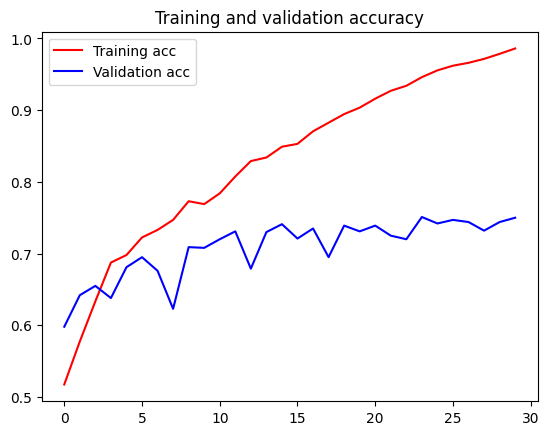

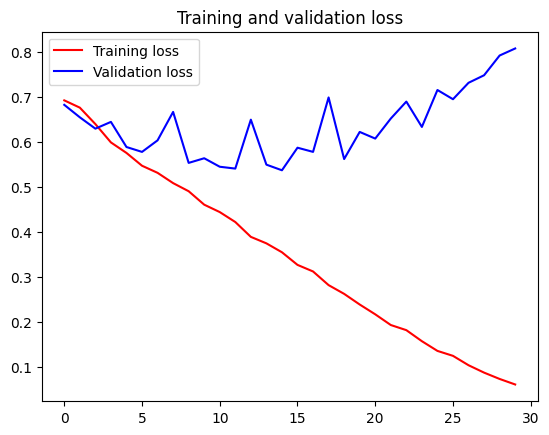

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Observe que a acurácia dos dados de treinamento aumenta linearmente ao longo do tempo até atingir quase 100% (e validação não passa de 70%).

A validation loss atinge seu mínimo depois de apenas cinco épocas, e a train loss continua diminuindo linearmente até atingir quase 0.

Como temos apenas poucas amostras de treinamento (2000), o maior risco é de overfitting (poderíamos resolver o problema com dropout). 

No entanto, usaremos uma técnica muito como para visão computacional que pode solucionar o problema de overfitting: **data augmentation**



Mas, antes de abordarmos o assunto de data augmentation, vamos aprender a realizar algumas poredições no nosso modelo treinado.

**Realizando Predições**

Obtendo uma imagem de exemplo usando no treinamento (veja que esta imagem já está pré-processada)

In [14]:
data_batch, labels_batch = validation_generator[0]
print('data batch shape:', data_batch.shape)
print(data_batch[5].shape)

x = data_batch[5]

data batch shape: (20, 150, 150, 3)
(150, 150, 3)


Observe o shape da imagem (150, 150, 3), para a predição temos que converter para um tensor 4D

In [15]:
x = x.reshape(1, 150, 150, 3)

print (x.shape)

(1, 150, 150, 3)


Realizando a inferência: a loss function binary_crossentropy retorna um valor de probabilidade entre 0 e 1 para a classificação binária (cat - 0 e dog - 1)

In [16]:
prob = model.predict(x)

print(prob)

1/1 [==============================] - 0s 256ms/step
[[0.00395461]]


Abrindo uma imagem diretamente do diretório. Obsserve que agora a imagem não está pre-processada

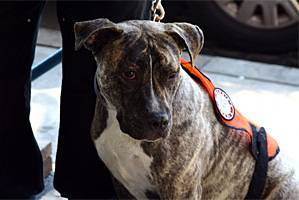

In [17]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2

path = os.path.join(base_dir, 'validation/dogs/dog.2010.jpg')

img = cv2.imread(path) 
cv2_imshow(img)

In [18]:
print(img.shape)

(200, 299, 3)


Vamos carregar a imagem usando PIL (biblioteca para processamento de imagens em Python)

In [19]:
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from PIL import Image

img = load_img(path, target_size=(150, 150))

Rescale de cada pixels de (0 a 255) para [0, 1]

In [20]:
from numpy import asarray

img = asarray(img)

print('Data Type: %s' % img.dtype)
print('Min: %.3f, Max: %.3f' % (img.min(), img.max()))

img = img.astype('float32')
img /= 255.0

print('Min: %.3f, Max: %.3f' % (img.min(), img.max()))

Data Type: uint8
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000


In [21]:
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

print(x.shape)

(1, 150, 150, 3)


In [22]:
prob = model.predict(x)

print(prob)

1/1 [==============================] - 0s 20ms/step
[[0.9989415]]


**Usando data augmentation**

O problema de overfitting foi causado por ter poucas amostras para aprender, ou seja, faz com que o modelo seja incapazes de generalizar para novos dados.

Data augmentation gera mais dados de treinamento a partir de amostras existentes de treinamento, por meio de várias transformações aleatórias que produzem novas imagens. 

O objetivo é que, durante o treinamento, nosso modelo nunca veja exatamente a mesma imagem duas vezes. Isso ajuda o modelo a se expor a mais aspectos dos dados e a generalizar melhor.

Você pude utilizar operações de processamento de imagens comuns para produzir novas amostras de dados a partir das imagens de treinamento.

Acesse para exemplos:

https://github.com/albumentations-team/albumentations

https://github.com/codebox/image_augmentor


No Keras, isso pode ser feito configurando várias transformações aleatórias a serem executadas nas imagens lidas pela nossa instância do ImageDataGenerator. 


In [23]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Estas são apenas algumas das opções disponíveis (para mais, consulte a documentação do Keras). 

rotation_range é um valor em graus (0-180), um intervalo no qual gira aleatoriamente as imagens.

width_shift e height_shift são intervalos dentro dos quais rotaciona aleatoriamente imagens na vertical ou na horizontal.

shear_range é para aplicar aleatoriamente transformações de cisalhamento.

zoom_range é para ampliar aleatoriamente as imagens.

horizontal_flip é para virar aleatoriamente metade das imagens horizontalmente

fill_mode é a estratégia usada para preencher pixels recém-criados, que podem aparecer após uma rotação ou uma mudança de largura / altura.

In [24]:
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

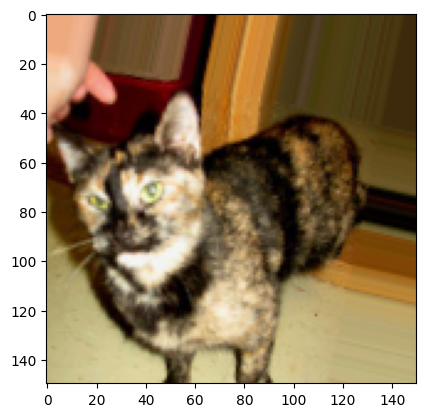

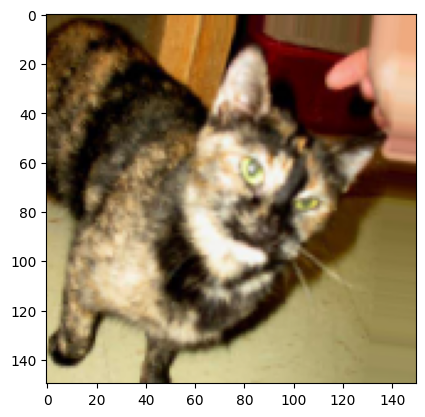

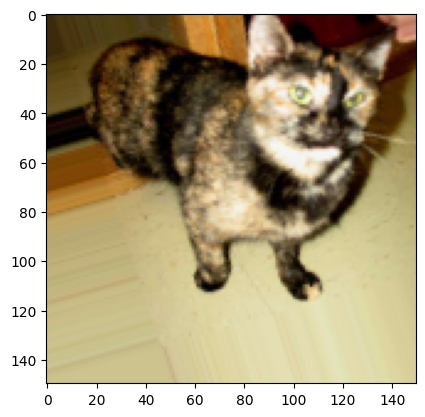

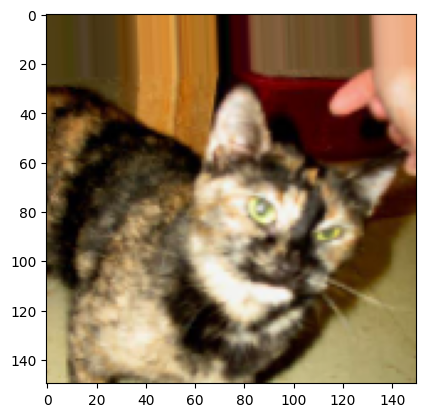

In [25]:
from tensorflow.keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

Se treinarmos uma nova rede usando data augmentation, a rede nunca verá duas vezes a mesma entrada. No entanto, isso pode não ser suficiente para se livrar completamente do problema de overfitting. Para isso, também adicionaremos uma camada Dropout ao modelo.

In [26]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

Treinando o modelo usando data augmentation e dropout



In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<ipython-input-27-4f9c21c15c65>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
100/100 [==============================] - 22s 191ms/step - loss: 0.6947 - acc: 0.4995 - val_loss: 0.6875 - val_acc: 0.6020
Epoch 2/30
100/100 [==============================] - 23s 233ms/step - loss: 0.6861 - acc: 0.5450 - val_loss: 0.6645 - val_acc: 0.6040
Epoch 3/30
100/100 [==============================] - 22s 217ms/step - loss: 0.6809 - acc: 0.5575 - val_loss: 0.6639 - val_acc: 0.5690
Epoch 4/30
100/100 [==============================] - 20s 195ms/step - loss: 0.6672 - acc: 0.5840 - val_loss: 0.6536 - val_acc: 0.6060
Epoch 5/30
100/100 [==============================] - 21s 208ms/step - loss: 0.6650 - acc: 0.5860 - val_loss: 0.6806 - val_acc: 0.5420
Epoch 6/30
100/100 [==============================] - 19s 195ms/step - loss: 0.6624 - acc: 0.5875 - val_loss: 0.6334 - val_acc: 0.6300
Epoch 7/30
100/100 [==============================] - 20s 196ms/step - loss: 0.6525 - acc: 0.6160 - val_loss: 0.6396 - val_acc: 0.6020
Epoch 8/30
100/100 [==============================] - 1

In [28]:
model.save('cats_and_dogs_small_2.h5')

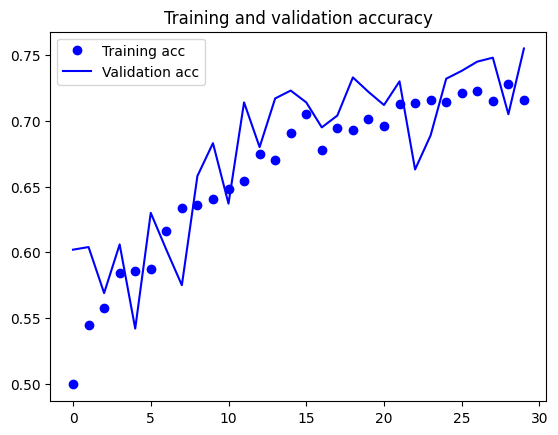

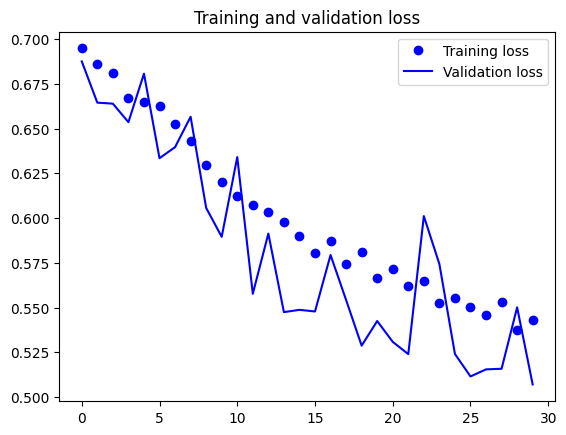

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Observe que agora não estamos mais enfrentando o problema de overfitting. 

As curvas de treinamento estão acompanhando de perto as curvas de validação.

Referência: François Chollet. Deep Learning with Python. November 2017  